# NoisyFarm - A farm animal sound classifier

***

## Objectives

>The aim of this toy project is to create an animal sound clasifier able to recognize different farm animal based on audio.

We see the following points:

- Explore state-fo-the-art audio clasifier network YAMNet and test it
- Use transfer learning to build a model using YAMNet embeddings to classify farm animal sounds.
- Evaluate the model.
- Wrap an end-to-end model ready for production. 







## Import libraries


In [2]:
import os

from IPython.display import Audio, Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import class_weight
import random

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import src.params as yamnet_params
import src.yamnet as yamnet_model

import warnings
%matplotlib inline 
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# YAMNet Model - Test a well know audio clasifier
***

## About YAMNet



[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet- YouTube Corpus](http://g.co/audioset) corpus.

>Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds.

>The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings, and the log mel spectrogram.




### Loading YAMNet from TensorFlow Hub

First, I will test the pre-trained YAMNet model and see the results of  farm animal sounds classifying audio. 



In [4]:
#Define parameters
params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)
#Load the model
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('../models/YAMNet/yamnet.h5')

Sample rate = 16000


With the model loaded, I download a sample WAV file wiht the sound of a rooster to run the inference.


In [5]:
testing_wav_file_name = tf.keras.utils.get_file('rooster.wav',
                                                'https://storage.googleapis.com/audioset/yamalyzer/audio/rooster.wav',
                                                cache_dir='../',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

../test_data/rooster.wav


The following define a function to load audio files. The returned `wav_data` from is normalized to values in the `[-1.0, 1.0]` range.

In [6]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

2022-04-04 22:19:09.246817: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


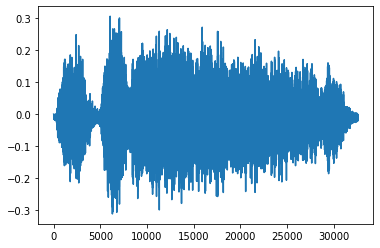

In [7]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
Audio(testing_wav_data,rate=16000)

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize.

In [9]:
class_names = yamnet_model.class_names('../models/YAMNet/yamnet_class_map.csv')

for name in class_names[:20]:
    print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.


In [10]:
scores, embeddings, spectrogram = yamnet(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (12, 1024)


The model correctly inferred an animal sound, but it's not specifyng which one. In this project the goal is to increase the model's accuracy for specific classes such as: `pig,rooster,sheep,etc`.

***
# Build a farm sound clasifier using transfer learning 

***

>In this part, I will describe how to use YAMNet as a high-level feature extractor - the 1,024-dimensional embedding output and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, I will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. 

I already used this approach to overcome highly imbalanced datasets, obtaining really good results!

## ESC-50 dataset

The [ESC-50 dataset](https://github.com/karolpiczak/ESC-50#repository-content) ([Piczak, 2015](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)) is a labeled collection of 2,000 five-second long environmental audio recordings. The dataset consists of 50 classes, with 40 examples per class.



### Explore the data

The metadata for each file is specified in the csv file at `./datasets/ESC-50-master/meta/esc50.csv`
and all the audio files are in `./datasets/ESC-50-master/audio/`



In [18]:
esc50_csv = '../data/ESC-50-master/meta/esc50.csv'
base_data_path = '../data/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [19]:
# List of categories
pd_data['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

### Filter the data

With the data is stored in the `DataFrame`, I apply some transformations:

- Filter out rows and use only the selected classes. 
- Amend the filename to have the full path. 
- Change targets to be within a specific range.

In [20]:
my_classes = ['dog','chirping_birds','crow','sheep','cow','cat','hen', 'rooster', 'pig']

map_class_to_id = {k: v for v, k in enumerate(my_classes)}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,../data/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
1,../data/ESC-50-master/audio/1-100038-A-14.wav,1,1,chirping_birds,False,100038,A
8,../data/ESC-50-master/audio/1-103298-A-9.wav,1,2,crow,False,103298,A
14,../data/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
29,../data/ESC-50-master/audio/1-121951-A-8.wav,1,3,sheep,False,121951,A
49,../data/ESC-50-master/audio/1-16568-A-3.wav,1,4,cow,False,16568,A
70,../data/ESC-50-master/audio/1-18074-A-6.wav,1,6,hen,False,18074,A
71,../data/ESC-50-master/audio/1-18074-B-6.wav,1,6,hen,False,18074,B
87,../data/ESC-50-master/audio/1-196660-A-8.wav,1,3,sheep,False,196660,A
88,../data/ESC-50-master/audio/1-196660-B-8.wav,1,3,sheep,False,196660,B


## Exploring the data

A couple of functions to have a look inside of the audio files. 

In [21]:
animals_images = {
  'dog': 'https://upload.wikimedia.org/wikipedia/commons/9/99/Brooks_Chase_Ranger_of_Jolly_Dogs_Jack_Russell.jpg', 
  'chirping_birds': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Minla_strigula_-_Doi_Inthanon.jpg/1024px-Minla_strigula_-_Doi_Inthanon.jpg', 
  'crow': 'https://upload.wikimedia.org/wikipedia/commons/a/a9/Corvus_corone_-near_Canford_Cliffs%2C_Poole%2C_England-8.jpg', 
  'sheep': 'https://upload.wikimedia.org/wikipedia/commons/2/2c/Flock_of_sheep.jpg', 
  'cow': 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Cow_%28Fleckvieh_breed%29_Oeschinensee_Slaunger_2009-07-07.jpg/1024px-Cow_%28Fleckvieh_breed%29_Oeschinensee_Slaunger_2009-07-07.jpg', 
  'cat':'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg',
  'hen':'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Cascais_Costa_do_Esteril_52_%2836583204550%29.jpg/301px-Cascais_Costa_do_Esteril_52_%2836583204550%29.jpg',
  'rooster':'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Rooster04_adjusted.jpg/1200px-Rooster04_adjusted.jpg',
  'pig':'https://upload.wikimedia.org/wikipedia/commons/b/bf/Pig_farm_Vampula_9.jpg' 
}


def get_random_audio_file():
    random_audio_path = random.choice(filtered_pd['filename'].values)
    return random_audio_path


def show_animal_data(audio_path):
    
    audio_data = load_wav_16k_mono(audio_path)
    category = filtered_pd['category'][filtered_pd['filename'] == audio_path].values
    print(f'Animal class: {category}')
    
    display(Audio(audio_data,rate=16000, autoplay=True))
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(audio_data)
    plt.show()
    display(Image(url=animals_images[category[0]]))
    



Animal class: ['rooster']


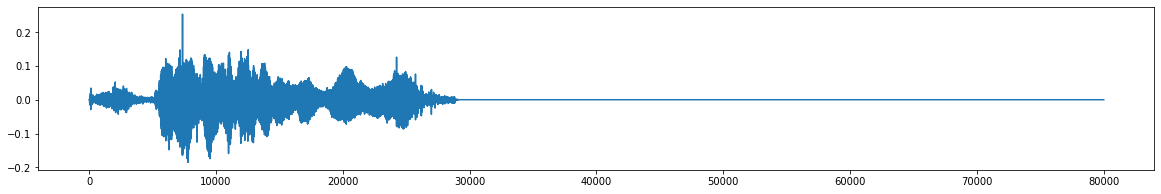

In [24]:
random_audio = get_random_audio_file()
show_animal_data(random_audio)

### Load the audio files and retrieve embeddings

I will apply the `load_wav_16k_mono` and prepare the WAV data for the model. For this reason I will convert the arrays from the dataframe into a `tf.Tensor`.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

In [25]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [26]:
# Using load_wav_16k_mono funstions in the data set
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

I will use each frame as one input. Therefore, it's necesary to create a new column that has one frame per row. You also need to expand the `labels` and the `fold` column to proper reflect these new rows.



In [27]:
# applies the embedding extraction from YAMNet model to a wav data
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

ESC-50 is arranged into five uniformly-sized cross-validation `fold`s, such that clips from the same original source are always in the same `fold` - find out more in the [ESC: Dataset for Environmental Sound Classification](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) paper.


I will perform the following steps:
- To split the data into train, validation and test sets I use the `fold` column .


- The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [28]:
cached_ds = main_ds.cache()

train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

# Prepare Tensor for training
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create the model

Here I define a very simple shallow model to train in my new farm animal dataset.



In [29]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dense(len(my_classes),activation='softmax')
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 529,417
Trainable params: 529,417
Non-trainable params: 0
_________________________________________________________________


In [30]:
opt = tf.keras.optimizers.SGD(
    learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=False, name="SGD")


my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=opt,
                 metrics=['accuracy'])


callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.9,patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20,verbose=1),
]

In [31]:
history = my_model.fit(train_ds,
                       epochs=500,
                       validation_data=val_ds,
                       callbacks=callbacks)

Epoch 1/500
284/284 [==============================] - 123s 402ms/step - loss: 1.9179 - accuracy: 0.3621 - val_loss: 1.8957 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 2/500
284/284 [==============================] - 2s 7ms/step - loss: 1.6031 - accuracy: 0.5854 - val_loss: 1.6201 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 3/500
284/284 [==============================] - 2s 7ms/step - loss: 1.3958 - accuracy: 0.6598 - val_loss: 1.4296 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 4/500
284/284 [==============================] - 3s 9ms/step - loss: 1.2496 - accuracy: 0.6943 - val_loss: 1.2817 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 5/500
284/284 [==============================] - 3s 9ms/step - loss: 1.1496 - accuracy: 0.7149 - val_loss: 1.1940 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 6/500
284/284 [==============================] - 3s 12ms/step - loss: 1.0761 - accuracy: 0.7238 - val_loss: 1.1086 - val_accuracy: 0.6379 - lr: 0.0010
Epoch 7/500
284/284 [==============================] - 3s 1

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [32]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

95/95 [==============================] - 1s 3ms/step - loss: 0.7988 - accuracy: 0.7255
Loss:  0.7987571358680725
Accuracy:  0.7255290746688843


Done! This is the best value I can get for now. A lot of operations can be done to the improve performance of the model. 

Some approaches to consider:

- Get more data from other datasets.
- Play around with regularozation.
- Test other activation functions and optmizers.
- Add more hiddden layers. 

## Sparse categorical accuracy vs Epochs

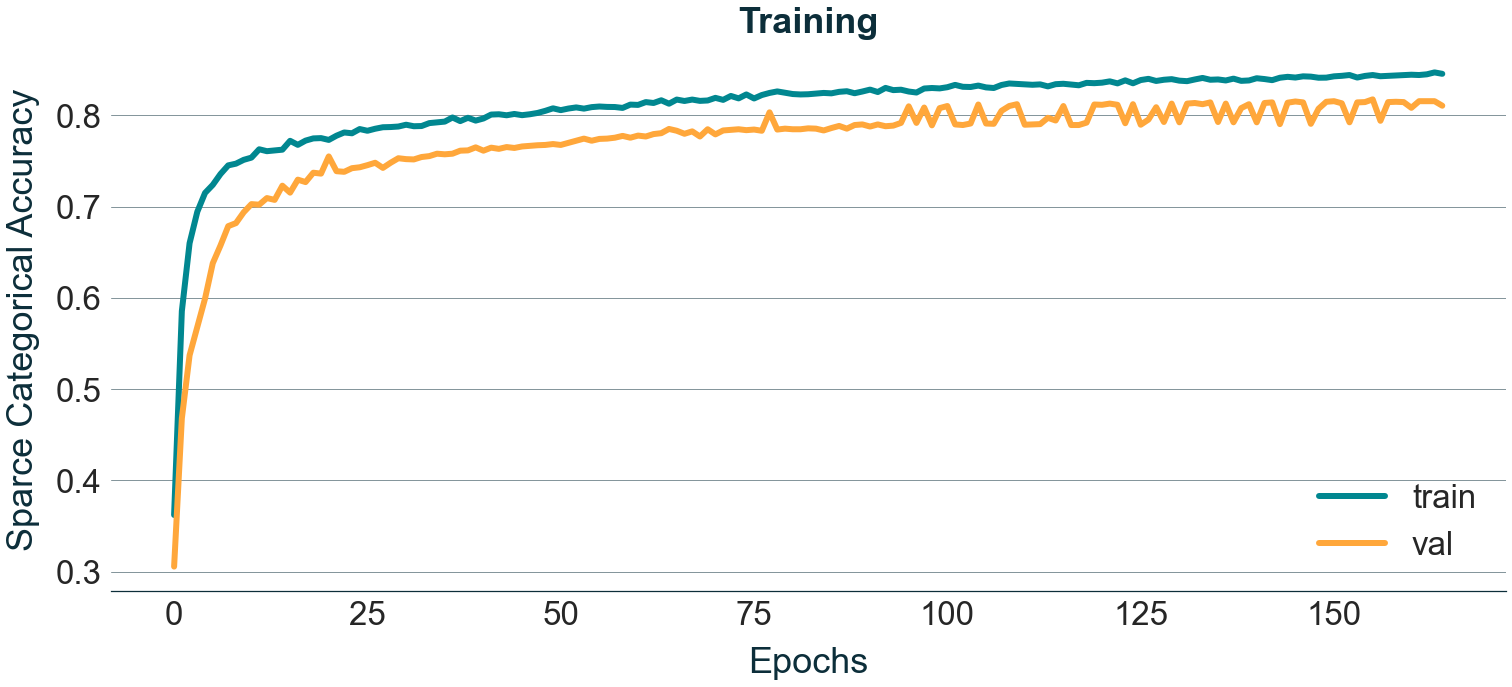

In [33]:
sns.set(font_scale=3)
plt.style.use('seaborn-ticks')
metric = "accuracy"

fig, ax = plt.subplots(figsize=(25, 10))
# plt.figure(figsize=(20,5))
plt.plot(history.history[metric],color='#018790',linewidth=6)
plt.plot(history.history["val_" + metric],color='#ffa73b',linewidth=6)
plt.legend(["train", "val"], loc="best")
# plt.show()

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#0c2e3a')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#0c2e3a',alpha=0.5)
ax.xaxis.grid(False)


# Add labels and a title.
ax.set_xlabel('Epochs', labelpad=15, color='#0c2e3a')
ax.set_ylabel('Sparce Categorical Accuracy', labelpad=15, color='#0c2e3a')
ax.set_title('Training', pad=15, color='#0c2e3a',
             weight='bold')
# plt.savefig('Training_LSTM.png', transparent=True)
plt.show()
plt.close()

## Confusion matrix

Confusion matrix is a common way to visualize the performace of the model to clasify classes.

Other metrics that can be useful for this type of task are `Accuracy`,`Precision`,`Recall`,`F1 score` and `ROC AUC`.

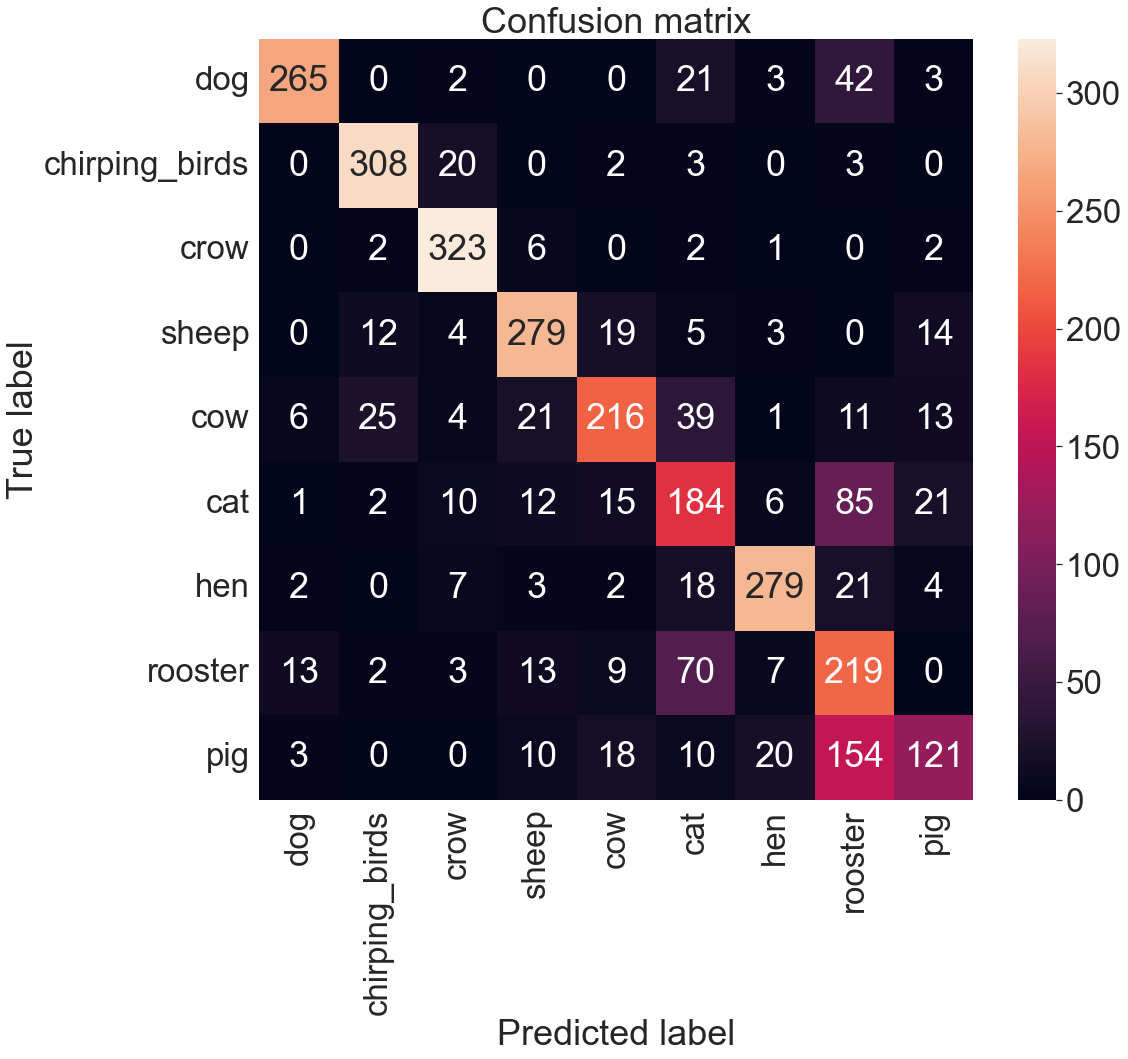

In [34]:

predicted = my_model.predict(test_ds)
pred_labels = predicted.argmax(axis=1)
true_labels= np.concatenate([y for x, y in test_ds], axis=0)

LABELS = my_classes
confusion_matrix = tf.math.confusion_matrix(true_labels, pred_labels)

# Normalise
# cmn = confusion_matrix / np.sum(confusion_matrix)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Some extra!
***

## Test model

Next, I will test the new model on the embedding from the previous test (rooster.wav) using YAMNet only.


In [35]:
# Extract embeddings
scores, embeddings, spectrogram = yamnet(testing_wav_data)
# Feed the new model
result = my_model(embeddings).numpy()
#Results
inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: rooster


# Save a model that can directly take a WAV file as input
***
>The new model works when you give it the embeddings from YAMNet as input. In a real-world scenario, I want to use audio data as a direct input.To do that, I will combine YAMNet with the model I trained into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving, you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [36]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [37]:
saved_model_path = '../models/noisy-farm/'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

2022-04-05 09:40:43.951540: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model architecture

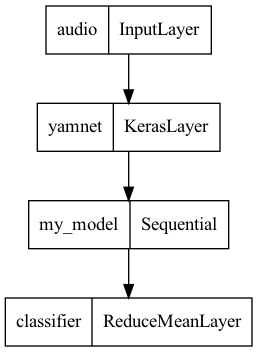

In [38]:
tf.keras.utils.plot_model(serving_model)

Now I will load the saved model to verify that it works as expected.

In [39]:
reloaded_model = tf.saved_model.load(saved_model_path)

And for the final test

In [40]:
reloaded_results = reloaded_model(testing_wav_data)
animal = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {animal}')

The main sound is: rooster


## Some more testing

The model is ready.

Let's compare it to YAMNet on another test case.

In [41]:
testing_wav_file_name_2 = '../test_data/cow2.wav'

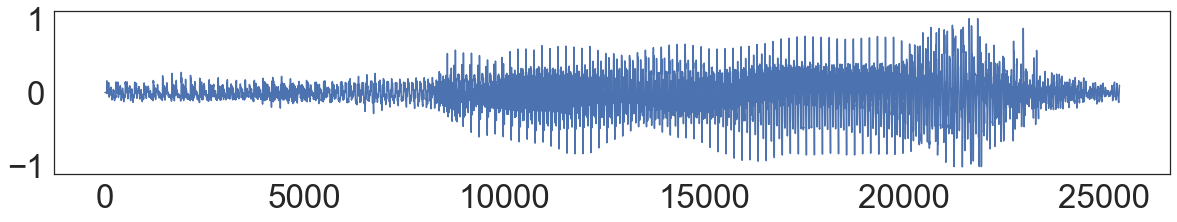

In [43]:

waveform = load_wav_16k_mono(testing_wav_file_name_2)
_ = plt.plot(waveform)


Audio(waveform, rate=16000)

In [47]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
print(f'[YAMNet] The main sound is: {inferred_class}')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
print(f'[NoisyFarm model] The main sound is: {your_inferred_class}')

[YAMNet] The main sound is: Music
[NoisyFarm model] The main sound is: cow
